# Lab 2: Markov Blanket in the IID Scenario

This notebook demonstrates:
1. Loading generated datasets with true DAG structure
2. Visualizing the true causal graph
3. Introduce three feature selection methods and corresponding training receipes:
    - Full feature set
    - Causal discovery based Markov Blanket search (CD-MB)
    - L1 loss
    - Oracle Markov Blanket (Oracle-MB)
4. Comparing results

In [1]:
%load_ext watermark
%watermark -a "Shu Wan" -v

%load_ext autoreload
%autoreload 2

Author: Shu Wan

Python implementation: CPython
Python version       : 3.12.0
IPython version      : 9.6.0



In [2]:
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_dataset

from blanket.feature_selection import (
    direct_lingam_selector,
    ges_selector,
    notears_selector,
    pc_selector,
)
from blanket.models import (
    linear_l1_regression,
    linear_regression,
)

from blanket.metrics import adjacency_confusion, jaccard_score, reduction_rate, shd
from blanket.plots import plot_adjmat, plot_graph

## 1. Load Dataset and Select Example

In [3]:
# Load dataset
train = load_dataset(path="CSE472-blanket-challenge/phase1-dataset", split='train', name='linear')

train.features

README.md: 0.00B [00:00, ?B/s]

linear_train.jsonl:   0%|          | 0.00/148M [00:00<?, ?B/s]

linear_test.jsonl:   0%|          | 0.00/35.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/720 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/180 [00:00<?, ? examples/s]

{'data_id': Value('string'),
 'graph_id': Value('string'),
 'X': List(List(Value('float64'))),
 'y': List(Value('float64')),
 'adjacency_matrix': List(List(Value('int64'))),
 'feature_mask': List(Value('int64')),
 'fs_method': Value('string'),
 'num_nodes': Value('int64'),
 'num_edges': Value('int64'),
 'density': Value('float64'),
 'graph_generation_method': Value('string')}

In [4]:
train_example = train[70]

X = np.asarray(train_example["X"])
y = np.asarray(train_example["y"])
adj_mat = np.asarray(train_example["adjacency_matrix"])
num_nodes = train_example["num_nodes"]
density = train_example["density"]
mb = np.asarray(train_example["feature_mask"])

## 2. Visualize True DAG and Adjacency Matrix

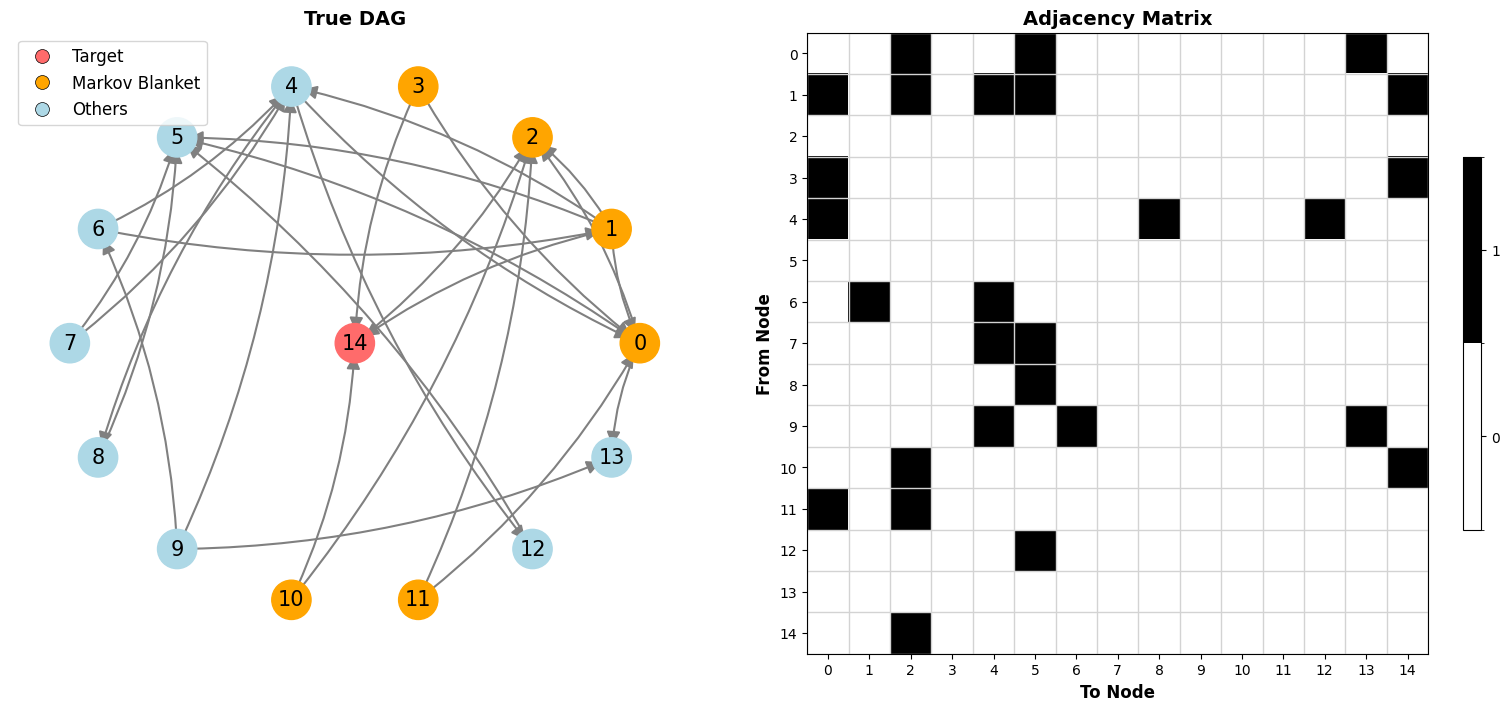

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7), constrained_layout=True)

plot_graph(adj_mat, figsize=(5, 5), ax=axes[0], title="True DAG")

plot_adjmat(
    adj_mat,
    title="Adjacency Matrix",
    figsize=(5, 5),
    ax=axes[1],
)

plt.show()

## 3. PC-based MB Discovery

In [6]:
pc_feature, pc_adjmat = pc_selector(X, y, alpha=0.05, ci_test="fisherz", variant="stable")
ges_feature, ges_adjmat = ges_selector(X, y, criterion="bic", method="scatter")
direct_lingam_feature, direct_lingam_adjmat = direct_lingam_selector(
    X, y, measure="pwling", thresh=0.3
)
notears_feature, notears_adjmat = notears_selector(X, y, lambda1=0.1, loss_type="l2")

In [7]:
# Compute graph metrics (SHD, precision, recall, F1) and MB metrics for each discovered graph

cdmb_results = {
    "PC": (pc_feature, pc_adjmat),
    "GES": (ges_feature, ges_adjmat),
    "DirectLiNGAM": (direct_lingam_feature, direct_lingam_adjmat),
    "NOTEARS": (notears_feature, notears_adjmat),
}

rows = []
for name, results in cdmb_results.items():
    feature = results[0]
    adj = results[1]
    shd_val = shd(adj_mat, adj)
    precision, recall, f1 = adjacency_confusion(adj_mat, adj)

    mb_jaccard = jaccard_score(mb, feature)
    mb_size = int(np.sum(feature))
    mb_reduction = reduction_rate(feature)

    rows.append(
        {
            "Method": name,
            "SHD": int(shd_val),
            "Precision": float(precision),
            "Recall": float(recall),
            "F1 Score": float(f1),
            "MB Jaccard": float(mb_jaccard),
            "MB Size": mb_size,
            "Reduction Rate": float(mb_reduction),
        }
    )

# Create and display comparison table
comparison_df = pd.DataFrame(rows)
comparison_df.sort_values(by="F1 Score", ascending=False, inplace=False).reset_index(drop=True)


,Method,SHD,Precision,Recall,F1 Score,MB Jaccard,MB Size,Reduction Rate
0,PC,12,0.857143,0.666667,0.750000,0.333333,2,0.857143
1,GES,34,0.414634,0.629630,0.500000,0.833333,5,0.642857
2,NOTEARS,20,0.888889,0.296296,0.444444,0.333333,2,0.857143
3,DirectLiNGAM,36,0.320000,0.296296,0.307692,0.500000,3,0.785714


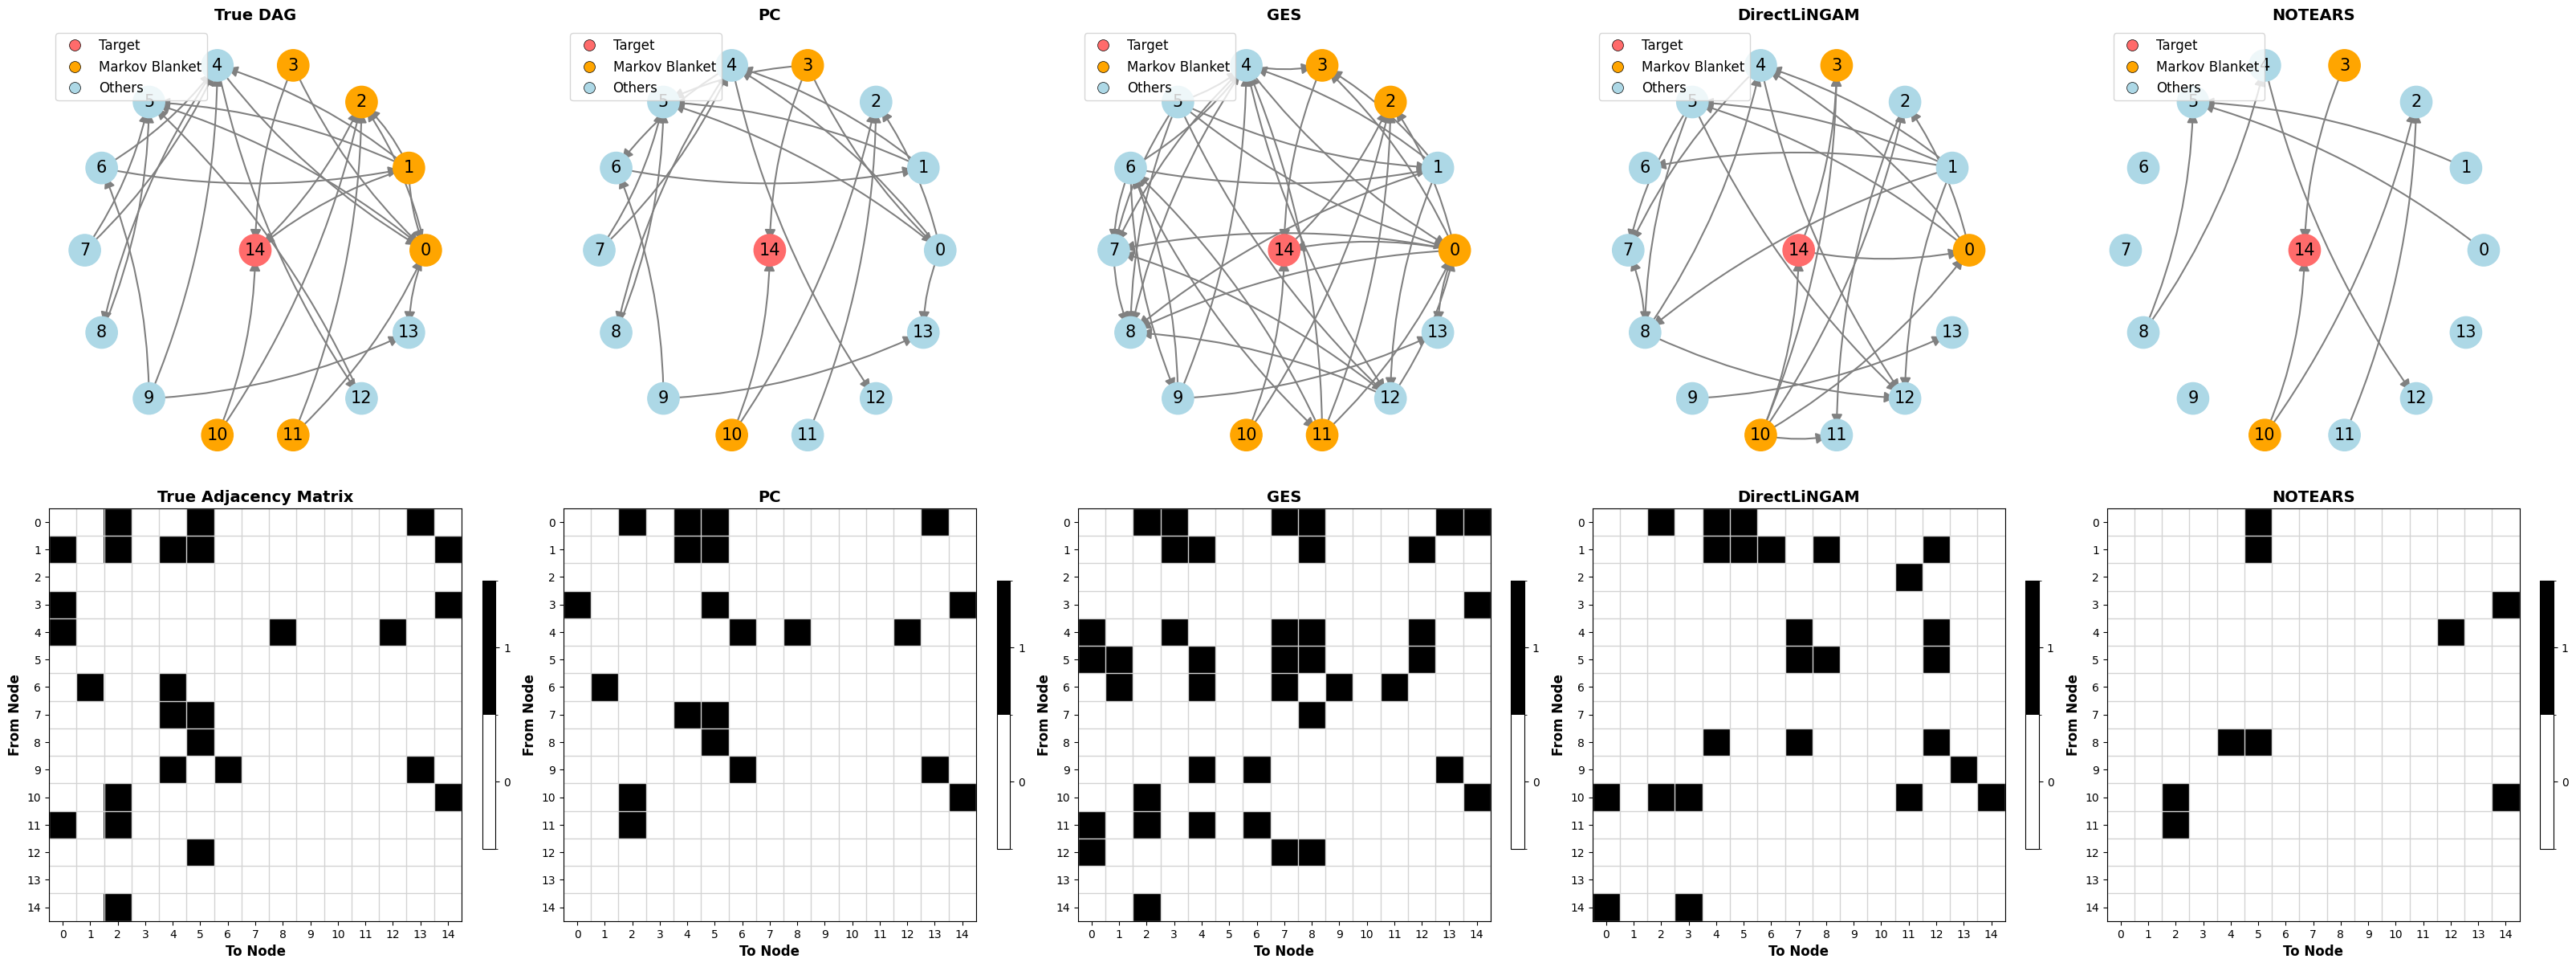

In [8]:
# visualize the results

num_methods = len(cdmb_results)
fig, axes = plt.subplots(2, num_methods + 1, figsize=(num_methods * 8, 12), constrained_layout=True)

plot_graph(
    adj_mat,
    figsize=(5, 5),
    title="True DAG",
    ax=axes[0, 0],
)

plot_adjmat(
    adj_mat,
    title="True Adjacency Matrix",
    figsize=(5, 5),
    ax=axes[1, 0],
)

for i, (name, results) in enumerate(cdmb_results.items(), 1):
    adj = results[1]
    plot_graph(
        adj,
        figsize=(5, 5),
        title=f"{name}",
        ax=axes[0, i],
    )

    plot_adjmat(
        adj,
        title=f"{name}",
        figsize=(5, 5),
        ax=axes[1, i],
    )

plt.show()

## 5. Define Training Function and Prepare Data


explain three [feature selection methods](https://sebastianraschka.com/faq/docs/feature_sele_categories.html)
1. filter: select feature by some metric with a threshold (e.g., $corr(X_i, y) > 0.8$)
2. wrapper: Use a wrapper model to perform feature selection. CB-MS
3. embedded: feature selection and training are integrated together. L1 regularization

We focus on wrapper and embedded methods

They have quite different training receipe

For Wrapper method
1. use the wrapper model to find optimal feature set
2. train a model using the feature set

For embedded method
1. train a model with embedded method
2. find optimal feature set
3. train the model again with the new feature set

In [10]:
# Train linear models with different feature selections
from sklearn.model_selection import train_test_split

print("\n=== Training Linear Models ===")

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = (X_train, y_train)
test_data = (X_test, y_test)

results = {}

# 1. Full features
results["full"] = linear_regression(train_data, test_data, feature_mask=None)

# 2. CD-MB methods (PC, GES, DirectLiNGAM, NOTEARS)
results["PC"] = linear_regression(train_data, test_data, feature_mask=pc_feature)
results["GES"] = linear_regression(train_data, test_data, feature_mask=ges_feature)
results["DirectLiNGAM"] = linear_regression(train_data, test_data, feature_mask=direct_lingam_feature)
results["NOTEARS"] = linear_regression(train_data, test_data, feature_mask=notears_feature)

# 3. L1 feature selection
l1_result = linear_l1_regression(train_data, test_data, alpha=0.05)
results["L1"] = l1_result
l1_feature = l1_result["feature_mask"]

# 4. Oracle (true Markov Blanket)
results["Oracle"] = linear_regression(train_data, test_data, feature_mask=mb)

print(f"Trained {len(results)} models")



=== Training Linear Models ===
Trained 7 models


In [11]:
# Display results sorted by RMSE

df_results = pd.DataFrame({
    'Model': list(results.keys()),
    'RMSE': [results[k]['rmse'] for k in results.keys()],
    'MAE': [results[k]['mae'] for k in results.keys()],
    'R2': [results[k]['r2'] for k in results.keys()],
    'Features': [results[k]['n_features'] for k in results.keys()]
})

df_results.sort_values('RMSE', ascending=True).reset_index(drop=True)


,Model,RMSE,MAE,R2,Features
0,Oracle,0.519150,0.402435,0.551372,6
1,GES,0.520170,0.405945,0.549608,5
2,PC,0.522429,0.410172,0.545688,2
3,NOTEARS,0.522429,0.410172,0.545688,2
4,DirectLiNGAM,0.525431,0.409552,0.540451,3
5,L1,0.529324,0.411330,0.533616,4
6,full,0.530717,0.411980,0.531158,14


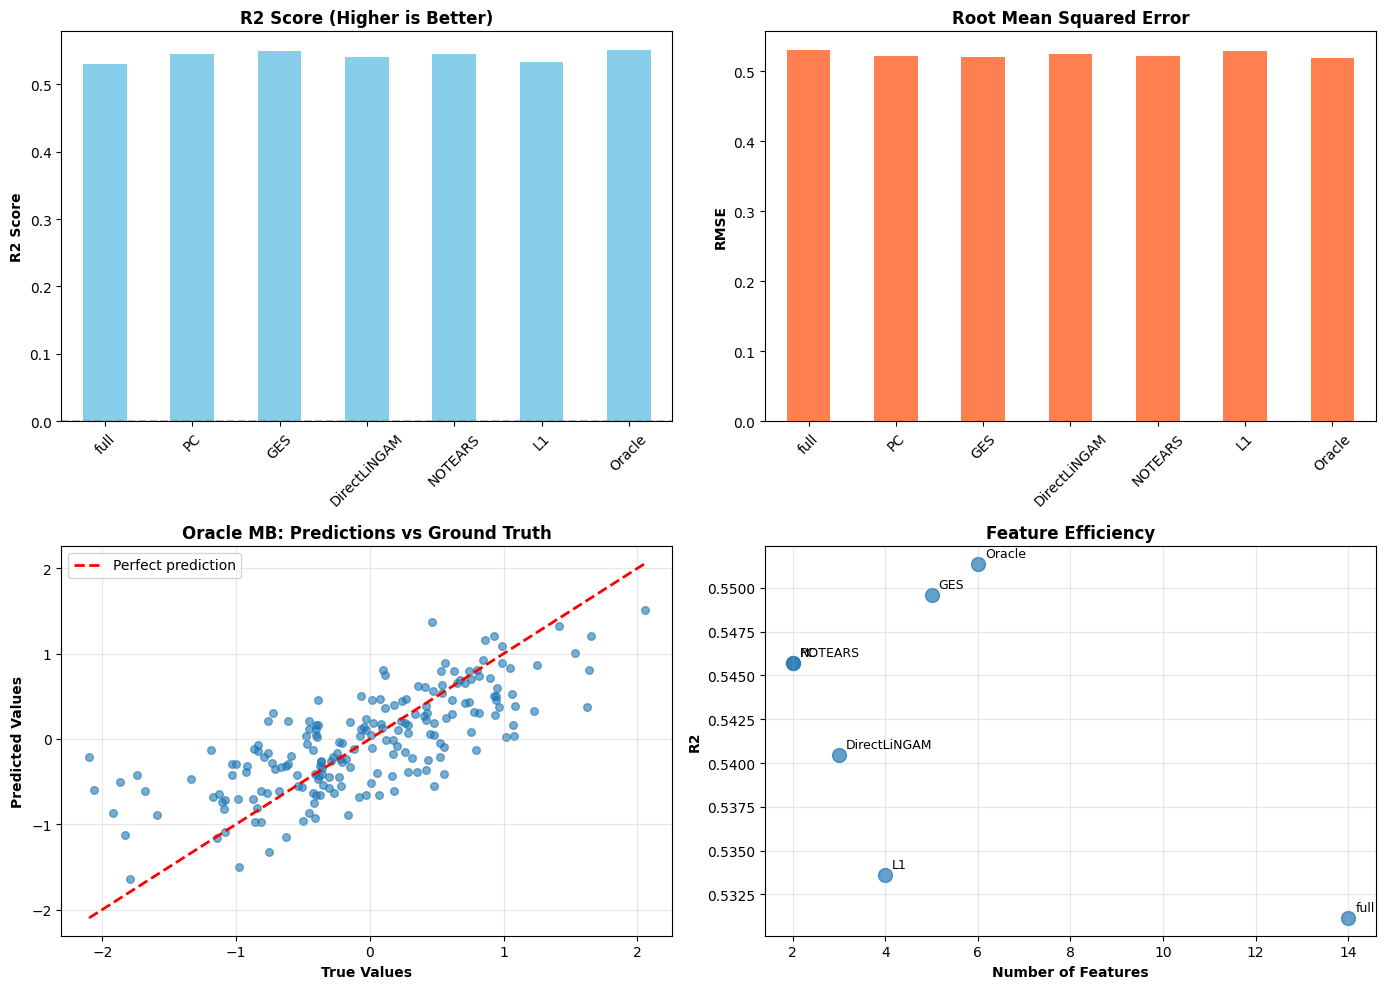

In [12]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. R2 comparison
ax1 = axes[0, 0]
df_results.plot(x='Model', y='R2', kind='bar', ax=ax1, color='skyblue', legend=False)
ax1.set_ylabel('R2 Score', fontweight='bold')
ax1.set_title('R2 Score (Higher is Better)', fontweight='bold')
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=45)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# 2. RMSE comparison
ax2 = axes[0, 1]
df_results.plot(x='Model', y='RMSE', kind='bar', ax=ax2, color='coral', legend=False)
ax2.set_ylabel('RMSE', fontweight='bold')
ax2.set_title('Root Mean Squared Error', fontweight='bold')
ax2.set_xlabel('')
ax2.tick_params(axis='x', rotation=45)

# 3. Predictions vs Ground Truth (Oracle MB)
ax3 = axes[1, 0]
y_pred_oracle = results['Oracle']['predictions']
y_test_oracle = results['Oracle']['truths']
ax3.scatter(y_test_oracle, y_pred_oracle, alpha=0.6, s=30)
ax3.plot([y_test_oracle.min(), y_test_oracle.max()], [y_test_oracle.min(), y_test_oracle.max()],
            'r--', lw=2, label='Perfect prediction')
ax3.set_xlabel('True Values', fontweight='bold')
ax3.set_ylabel('Predicted Values', fontweight='bold')
ax3.set_title('Oracle MB: Predictions vs Ground Truth', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Feature count vs R2 Performance
ax4 = axes[1, 1]
ax4.scatter(df_results['Features'], df_results['R2'], s=100, alpha=0.7)
for idx, row in df_results.iterrows():
    ax4.annotate(row['Model'], (row['Features'], row['R2']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax4.set_xlabel('Number of Features', fontweight='bold')
ax4.set_ylabel('R2', fontweight='bold')
ax4.set_title('Feature Efficiency', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Your Turn

From the above, we can see that Oracle MB gives the best prediction result on IID linear setting. However, it may just be a single case.

#### 1. Sample Size Analysis
**Objective**: Investigate how training data size affects feature selection methods.

- Vary the training set sizes (e.g., 50, 100, 500, 800)
- Plot RMSE vs. training sample size for each method
- Is Orcale MB robust in differernt sizes?
- Are CD-MB method robust on varing sizes?

#### 2. Nonlinear Relationships (Advanced)
**Objective**: Test methods on nonlinear datasets.

- Load the `'nonlinear'` subset: `load_dataset(path="CSE472-blanket-challenge/phase1-dataset", split='train', name='nonlinear')`
- Evaluate MLP models with feature selection
- Compare performance under nonlinear setting

## Bonus Points [5 points]

### Choose one:

#### 1. Graph Structure Analysis  
**Objective**: Understand how graph properties influence method performance.

- Test across graphs with varying:
  - **Density**:
  - **Markov Blanket size**: MB size w.r.t total feature size
  - **Graph size**: number of nodes

#### 2. L1 Regularization Tuning
**Objective**: Improve L1 feature selection through better hyperparameter selection.

- Implement adaptive alpha selection:
  - Cross-validation grid search
  - Use validation set to choose optimal alpha
  - Information criterion (AIC/BIC) based selection
- Compare with fixed alpha = 0.05
- **Key Question**: Can dynamic alpha selection make L1 competitive with Oracle MB?